In [1]:
    
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.quantum_info import Pauli
from qiskit.circuit import Parameter
from qiskit.quantum_info import Statevector, Operator
from qiskit.visualization import array_to_latex
from qiskit import Aer, execute
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import PauliEvolutionGate
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt

from qiskit_nature.second_q.operators import FermionicOp
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit_nature.settings import QiskitNatureSettings

from qiskit_algorithms import TrotterQRTE
from qiskit_algorithms import TimeEvolutionProblem


QiskitNatureSettings.use_pauli_sum_op = False





import numpy as np

In [2]:
# Setup

M = 2  #Number of Localizations
N = 2*M #total number of operators (Two positions times two spin polarizations)

zero = Operator(np.zeros((2**N,2**N)))


In [3]:
Tu = Statevector.from_int(1, 2**N)
Td = Statevector.from_int(2, 2**N)
Bu = Statevector.from_int(4, 2**N)
Bd = Statevector.from_int(8, 2**N)
vac = Statevector.from_int(0, 2**N)

In [4]:
# Define the Fermionic Operators
op_list = [
    # ({second_q-operator: coefficient}, num_qubits)
    ({"+_0 -_1": 1.0}, 4),  # a^dagger_0 a_1
    ({"+_1 -_0": 1.0}, 4),  # a^dagger_1 a_0
    ({"+_2 -_3": 1.0}, 4),  
    ({"+_3 -_2": 1.0}, 4),  
    ({"+_0 -_0": 1.0}, 4),  
    ({"+_1 -_1": 1.0}, 4),  
    ({"+_2 -_2": 1.0}, 4),  
    ({"+_3 -_3": 1.0}, 4),  
    ({"+_0 -_2": 1.0}, 4),  
    ({"+_1 -_3": 1.0}, 4),  
    ({"+_2 -_0": 1.0}, 4),  
    ({"+_3 -_1": 1.0}, 4),  
    
]


In [5]:
# Define spin operators
# Notice that spin operators are defined for top and bottom layer
sig_x = [zero, zero]
sig_x[0] = JordanWignerMapper().map(FermionicOp(op_list[1][0], num_spin_orbitals=N)) + JordanWignerMapper().map(FermionicOp(op_list[0][0], num_spin_orbitals=N))
sig_x[1] = JordanWignerMapper().map(FermionicOp(op_list[3][0], num_spin_orbitals=N)) + JordanWignerMapper().map(FermionicOp(op_list[2][0], num_spin_orbitals=N))

sig_y = [zero, zero]
sig_y[0] = 1j*JordanWignerMapper().map(FermionicOp(op_list[1][0], num_spin_orbitals=N)) - 1j*JordanWignerMapper().map(FermionicOp(op_list[0][0], num_spin_orbitals=N))
sig_y[1] = 1j*JordanWignerMapper().map(FermionicOp(op_list[3][0], num_spin_orbitals=N)) - 1j*JordanWignerMapper().map(FermionicOp(op_list[2][0], num_spin_orbitals=N))

sig_z = [zero, zero]
sig_z[0] = JordanWignerMapper().map(FermionicOp(op_list[4][0], num_spin_orbitals=N)) - JordanWignerMapper().map(FermionicOp(op_list[5][0], num_spin_orbitals=N))
sig_z[1] = JordanWignerMapper().map(FermionicOp(op_list[6][0], num_spin_orbitals=N)) - JordanWignerMapper().map(FermionicOp(op_list[7][0], num_spin_orbitals=N))


# Define position operators
# Notice

pos_x = [zero, zero]
pos_x[0] = JordanWignerMapper().map(FermionicOp(op_list[8][0], num_spin_orbitals=N)) + JordanWignerMapper().map(FermionicOp(op_list[10][0], num_spin_orbitals=N))
pos_x[1] = JordanWignerMapper().map(FermionicOp(op_list[11][0], num_spin_orbitals=N)) + JordanWignerMapper().map(FermionicOp(op_list[9][0], num_spin_orbitals=N))

pos_y = [zero, zero]
pos_y[0] = 1j*JordanWignerMapper().map(FermionicOp(op_list[8][0], num_spin_orbitals=N)) - 1j*JordanWignerMapper().map(FermionicOp(op_list[10][0], num_spin_orbitals=N))
pos_y[1] = 1j*JordanWignerMapper().map(FermionicOp(op_list[11][0], num_spin_orbitals=N)) - 1j*JordanWignerMapper().map(FermionicOp(op_list[9][0], num_spin_orbitals=N))


pos_z = [zero, zero]
pos_z[0] = JordanWignerMapper().map(FermionicOp(op_list[4][0], num_spin_orbitals=N)) - JordanWignerMapper().map(FermionicOp(op_list[6][0], num_spin_orbitals=N))
pos_z[1] = JordanWignerMapper().map(FermionicOp(op_list[5][0], num_spin_orbitals=N)) - JordanWignerMapper().map(FermionicOp(op_list[7][0], num_spin_orbitals=N))



In [6]:
pos_x[0].simplify()

SparsePauliOp(['IYZY', 'IXZX'],
              coeffs=[0.5+0.j, 0.5+0.j])

In [7]:
# Define additional Hamiltonian terms

#total spin operators
Sx,Sy,Sz=0,0,0
for i in range(M):
    Sx += sig_x[i]
    Sy += sig_y[i]
    Sz += sig_z[i]


Sx = Sx.simplify()
Sy = Sy.simplify()
Sz = Sz.simplify()

    
#total location pauli operators
Lx,Ly,Lz=0,0,0
for i in range(2):
    Lx += pos_x[i]
    Ly += pos_y[i]
    Lz += pos_z[i]

Lx = Lx.simplify()
Ly = Ly.simplify()
Lz = Lz.simplify()




In [8]:
# Hamiltonian terms

def H_chargesplit(E):
    return E*Lz

def H_spinsplit(E):
    return E*Sz
    
def H_EDSR(alpha,w,t, phi=0):
    # return lambda t: (alpha[0]*sig_x[0]+alpha[1]*sig_x[1])/2*np.cos(w*t+phi) #+detune*Sz
    # return lambda t: (alpha[0]*(sig_x[0]).simplify+alpha[1]*(sig_x[1]).simplify())/2*np.cos(w*t+phi)  # included h.c. to make it hermitian
    return (alpha[0]*sig_x[0].simplify()+alpha[1]*sig_x[1].simplify())/2*np.cos(w*t+phi)

def H_EDSR_no_time(alpha):
    return (alpha[0]*sig_x[0].simplify()+alpha[1]*sig_x[1].simplify())/2
    
def H_LZSI(eps,w, t, phi=0):
    return eps/2*Lx#*np.cos(w*t+phi) #+detune*Lz


In [9]:
ident = np.array([[1, 0], [0, 1]])
pauli_y = np.array([[0, -1j], [1j, 0]])
pauli_x = np.array([[0, 1], [1, 0]])
pauli_z = np.array([[1, 0], [0, -1]])

def pauli_product(pauli_string):
    """Helper method to compute kronecker product of Paulis"""

    prod = 1
    for p in pauli_string:
        print(p, end="")
        if p == "I":
            prod = np.kron(prod, ident)
        if p == "X":
            prod = np.kron(prod, pauli_x)
        elif p == "Y":
            prod = np.kron(prod, pauli_y)
        elif p == "Z":
            prod = np.kron(prod, pauli_z)
    print("\n")

    return prod


def pauli_string_to_SparsePauliOp(pauli_string):
    """Helper method to convert a Pauli string to a SparsePauliOp"""
    return SparsePauliOp([pauli_string])



In [10]:
# Direct evoltution
initial_state = Tu

# Time evolution parameters

E_charge=0.015
E_spin  =1

alpha= (0.1,0)
eps  = 0.0255

on1=0                       #onset of first drive
T1=2*np.pi/eps*.5           #length of first drive
on2=1                       #wait before of second drive
T2=2*np.pi/.1               #length of second drive
chill=1 

T=on1+T1+on2+T2+chill

w_charge = 7*E_charge
w_spin   = E_spin*2


# Hamiltonians

H_0 = H_spinsplit(E_spin) + H_chargesplit(E_charge)

H_charge = H_0 + H_LZSI(eps, w_charge, 0)

problem = TimeEvolutionProblem(H_charge, initial_state=initial_state, time=T1)
trotter = TrotterQRTE()
trotter_result = trotter.evolve(problem)

final_stae = Statevector(trotter_result.evolved_state)

Running block 1...


  0%|          | 0/29 [00:00<?, ?it/s]

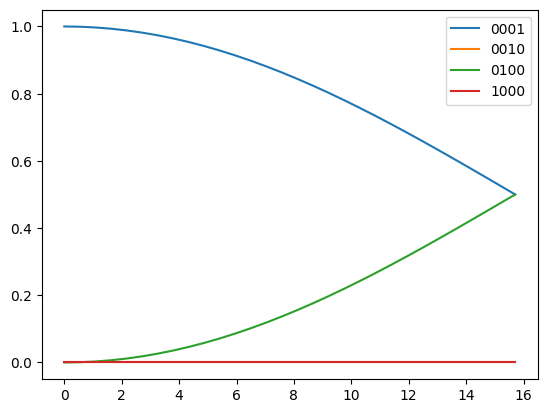

In [11]:
# Time evolution Block 1

initial_state = Tu

# Time evolution parameters

# E_charge=1
E_charge=0.001
E_spin  =1

alpha= (0.1,0)
eps  = 0.1

on1=0                       #onset of first drive
T1=2*np.pi/eps/4         #length of first drive
on2=1                       #wait before of second drive
T2=2*np.pi/eps            #length of second drive
chill=1 

T=on1+T1+on2+T2+chill

w_charge = 7*E_charge
w_spin   = E_spin*2

time_dep = False

# Hamiltonians

H_0 = H_spinsplit(E_spin) + H_chargesplit(E_charge)

H_charge = H_0 + H_LZSI(eps, w_charge, 0)

# Evolution block 1

N_steps_block1 = 30
T_block1_list = np.linspace(0, T1, N_steps_block1)
delta_t_block1 = T_block1_list[1] - T_block1_list[0]



# Store states after every time step

states_block1 = []
states_block1.append(initial_state)

if time_dep == True:
    H_charge_list = [H_0 + H_LZSI(eps, w_charge, t) for t in T_block1_list]

    print('Running block 1...')
    for i in tqdm(range(N_steps_block1-1)):
        problem = TimeEvolutionProblem(H_charge_list[i], initial_state=states_block1[-1], time=delta_t_block1)
        trotter = TrotterQRTE()
        result = trotter.evolve(problem)    
        states_block1.append(Statevector(result.evolved_state))

else:

    print('Running block 1...')
    for i in tqdm(range(N_steps_block1-1)):
        problem = TimeEvolutionProblem(H_charge, initial_state=states_block1[-1], time=delta_t_block1)
        trotter = TrotterQRTE(num_timesteps=1)
        result = trotter.evolve(problem)    
        states_block1.append(Statevector(result.evolved_state))


prob_dict_block1 = {'0001':[], '0010':[], '0100':[], '1000':[]}

for states in states_block1:
    if len(states.probabilities_dict())==1:
        prob_dict_block1['0001'].append(1)
        prob_dict_block1['0010'].append(0)
        prob_dict_block1['0100'].append(0)
        prob_dict_block1['1000'].append(0)
    else:
        for key in prob_dict_block1.keys():
            prob_dict_block1[key].append(states.probabilities_dict()[key])


# Plot the probabilities of the states in the computational basis vs time
plt.figure()
plt.plot(T_block1_list, prob_dict_block1['0001'], label='0001')
plt.plot(T_block1_list, prob_dict_block1['0010'], label='0010')
plt.plot(T_block1_list, prob_dict_block1['0100'], label='0100')
plt.plot(T_block1_list, prob_dict_block1['1000'], label='1000')
plt.legend()
plt.show()

# Interesting parameters:
# E_charge=100, N_steps_block1 = 200
# E_charge=0.1, N_steps_block1 = 200
# Compare N_steps_block1 = 190 and N_steps_block1 = 191
# Compare N_steps_block1 = 94 and N_steps_block1 = 95 at E_charge=0.1
# Compare N_steps_block1 = 30 and N_steps_block1 = 31 at E_charge=0.05, eps=0.1
# N_steps_block1 = 50, E_charge=1.15, E_spin=1, eps=0.64
# N_steps_block1 = 50, E_charge=0.035, E_spin=1, eps=0.0255

In [12]:
np.cos(T_block1_list*5)
# T_block1_list

array([ 1.        , -0.90757542,  0.64738628, -0.26752834, -0.161782  ,
        0.56118707, -0.85685718,  0.99413796, -0.94765317,  0.72599549,
       -0.37013816, -0.05413891,  0.46840844, -0.79609307,  0.97662056,
       -0.97662056,  0.79609307, -0.46840844,  0.05413891,  0.37013816,
       -0.72599549,  0.94765317, -0.99413796,  0.85685718, -0.56118707,
        0.161782  ,  0.26752834, -0.64738628,  0.90757542, -1.        ])

Running block 2...


  0%|          | 0/9 [00:00<?, ?it/s]

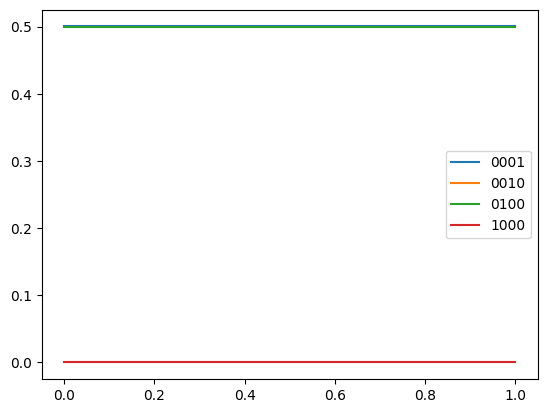

In [13]:
# Time evolution Block 2

N_steps_block2 = 10
T_block2_list = np.linspace(0, on2, N_steps_block2)

# Store states after every time step

states_block2 = []
states_block2.append(states_block1[-1])

print('Running block 2...')
for t in tqdm(T_block2_list[1:]):
    problem = TimeEvolutionProblem(H_0, initial_state=states_block2[-1], time=t)
    trotter = TrotterQRTE()
    result = trotter.evolve(problem)    
    states_block2.append(Statevector(result.evolved_state))


prob_dict_block2 = {'0000': [], '0001': [], '0010': [], '0011': [], 
                    '0100': [], '0101': [], '0110': [], '0111': [], 
                    '1000': [], '1001': [], '1010': [], '1011': [], 
                    '1100': [], '1101': [], '1110': [], '1111': []}

for states in states_block2:
    for key in states.probabilities_dict().keys():
        if states.probabilities_dict()[key] < 1e-15:
            prob_dict_block2[key].append(0)
        else:
            prob_dict_block2[key].append(states.probabilities_dict()[key])
    for key in prob_dict_block2.keys():
        if key not in states.probabilities_dict().keys():
            prob_dict_block2[key].append(0)


# Plot the probabilities of the states in the computational basis vs time
plt.figure()
plt.plot(T_block2_list, np.array(prob_dict_block2['0001']), label='0001')
plt.plot(T_block2_list, np.array(prob_dict_block2['0010']), label='0010')
plt.plot(T_block2_list, np.array(prob_dict_block2['0100']), label='0100')
plt.plot(T_block2_list, np.array(prob_dict_block2['1000']), label='1000')
plt.legend()
plt.show()


Running block 3...


  0%|          | 0/99 [00:00<?, ?it/s]

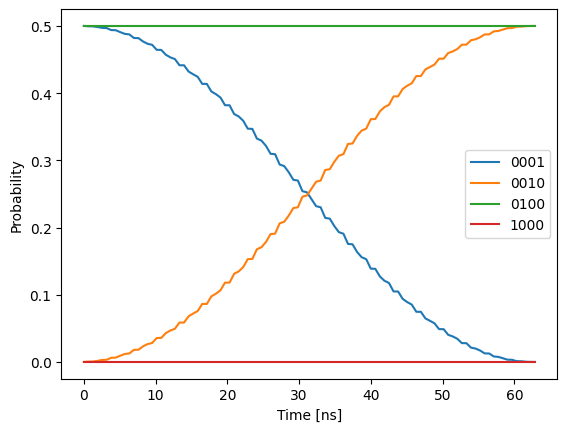

In [14]:
# Time evolution Block 3

N_steps_block3 = 100
T_block3_list = np.linspace(0, T2, N_steps_block3)
delta_t_block3 = T_block3_list[1] - T_block3_list[0]

# Updated H_0
E_charge = 1
E_spin = 1
w_spin = 2*E_spin

H_0 = H_spinsplit(E_spin) + H_chargesplit(E_charge)


# Create Hamiltonian list for EDSR
H_EDSR_list = []
for t_EDSR in T_block3_list:
    H_EDSR_list.append(H_0 + H_EDSR(alpha, w_spin, t_EDSR))

H_EDSR_no_time = H_0 + H_EDSR(alpha, 4.95, 0)*0.5

time_dep = True

# H_spin_list = []
# for H in H_EDSR_list:
#     H_spin_list.append(H + H_spinsplit(E_spin) + H_chargesplit(E_charge))

# Store states after every time step

states_block3 = []
states_block3.append(states_block2[-1])

print('Running block 3...')

if time_dep == True:

    for i in tqdm(range(N_steps_block3-1)):
        # problem = TimeEvolutionProblem(H_EDSR_list[i], initial_state=states_block3[-1], time=T_block3_list[i])
        problem = TimeEvolutionProblem(H_EDSR_list[i], initial_state=states_block3[-1], time=delta_t_block3)

        trotter = TrotterQRTE()
        result = trotter.evolve(problem)    
        states_block3.append(Statevector(result.evolved_state))

else:
    
    for i in tqdm(range(N_steps_block3-1)):
        problem = TimeEvolutionProblem(H_0 + H_EDSR_no_time, initial_state=states_block3[-1], time=delta_t_block3)
        trotter = TrotterQRTE(num_timesteps=1)
        result = trotter.evolve(problem)    
        states_block3.append(Statevector(result.evolved_state))


prob_dict_block3 = {'0000': [], '0001': [], '0010': [], '0011': [],
                    '0100': [], '0101': [], '0110': [], '0111': [],
                    '1000': [], '1001': [], '1010': [], '1011': [],
                    '1100': [], '1101': [], '1110': [], '1111': []}

for states in states_block3:
    for key in states.probabilities_dict().keys():
        if states.probabilities_dict()[key] < 1e-15:
            prob_dict_block3[key].append(0)
        else:
            prob_dict_block3[key].append(states.probabilities_dict()[key])
    for key in prob_dict_block3.keys():
        if key not in states.probabilities_dict().keys():
            prob_dict_block3[key].append(0)


# Plot the probabilities of the states in the computational basis vs time
plt.figure()
plt.plot(T_block3_list, np.array(prob_dict_block3['0001']), label='0001')
plt.plot(T_block3_list, np.array(prob_dict_block3['0010']), label='0010')
plt.plot(T_block3_list, np.array(prob_dict_block3['0100']), label='0100')
plt.plot(T_block3_list, np.array(prob_dict_block3['1000']), label='1000')
plt.xlabel('Time [ns]')
plt.ylabel('Probability')
plt.legend()
plt.show()

In [15]:
np.cos(w_spin*T_block3_list)

array([ 1.        ,  0.29692038, -0.82367658, -0.78605309,  0.35688622,
        0.99798668,  0.23575894, -0.85798341, -0.74526445,  0.41541501,
        0.99195481,  0.17364818, -0.88883545, -0.70147489,  0.47227107,
        0.9819287 ,  0.1108382 , -0.91610846, -0.65486073,  0.52722547,
        0.9679487 ,  0.04758192, -0.93969262, -0.60560969,  0.58005691,
        0.95007112, -0.01586596, -0.95949297, -0.55392006,  0.63055267,
        0.92836793, -0.07924996, -0.97542979, -0.5       ,  0.67850941,
        0.90292654, -0.14231484, -0.98743889, -0.44406661,  0.72373404,
        0.87384938, -0.20480667, -0.99547192, -0.38634513,  0.76604444,
        0.84125353, -0.26647381, -0.99949654, -0.32706796,  0.80527026,
        0.80527026, -0.32706796, -0.99949654, -0.26647381,  0.84125353,
        0.76604444, -0.38634513, -0.99547192, -0.20480667,  0.87384938,
        0.72373404, -0.44406661, -0.98743889, -0.14231484,  0.90292654,
        0.67850941, -0.5       , -0.97542979, -0.07924996,  0.92

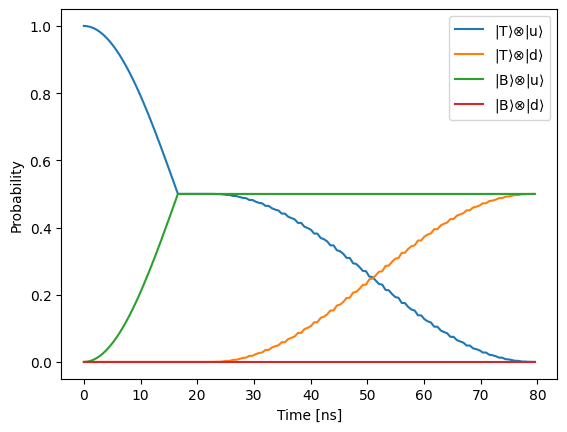

In [16]:
# Plot everything together
# Patch probabilities together an plot
prob_dict_tot = {'0001':[], '0010':[], '0100':[], '1000':[]}

state_names=['|T⟩$\otimes$|u⟩','|T⟩$\otimes$|d⟩','|B⟩$\otimes$|u⟩','|B⟩$\otimes$|d⟩']
state_label = ['0001', '0010', '0100', '1000']


list_0001 = prob_dict_block1[state_label[0]] + prob_dict_block2[state_label[0]] + prob_dict_block3[state_label[0]]
list_0010 = prob_dict_block1[state_label[1]] + prob_dict_block2[state_label[1]] + prob_dict_block3[state_label[1]]
list_0100 = prob_dict_block1[state_label[2]] + prob_dict_block2[state_label[2]] + prob_dict_block3[state_label[2]]
list_1000 = prob_dict_block1[state_label[3]] + prob_dict_block2[state_label[3]] + prob_dict_block3[state_label[3]]

prob_dict_tot['0001'] = list_0001
prob_dict_tot['0010'] = list_0010
prob_dict_tot['0100'] = list_0100
prob_dict_tot['1000'] = list_1000


T_total_list = np.linspace(0, T1 + on2 + T2, N_steps_block1+N_steps_block2+N_steps_block3)

plt.figure()
plt.plot(T_total_list, prob_dict_tot['0001'], label=state_names[0])
plt.plot(T_total_list, prob_dict_tot['0010'], label=state_names[1])
plt.plot(T_total_list, prob_dict_tot['0100'], label=state_names[2])
plt.plot(T_total_list, prob_dict_tot['1000'], label=state_names[3])

plt.xlabel('Time [ns]')
plt.ylabel('Probability')


plt.legend()

In [21]:
# Implement colour map

E_charge_list = np.linspace(-18,18, 10)
waiting_time_list = np.linspace(25, 100, 10)

# Sequence consists of 3 blocks
# 1. Charge splitting
# 2. Waiting time and Bloch rotation
# 3. Charge splitting

E_charge= -400
E_spin  = 1
E_charge_drive= 0

hbar = 6.582119569e2 #ueV*ps
alpha= (.1,0)
alph = .1
eps  = 11

drivetime= 57/hbar 



Running block 1...


  0%|          | 0/49 [00:00<?, ?it/s]

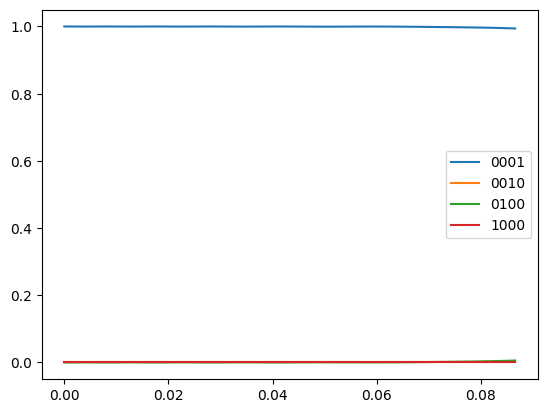

In [22]:
# Block 1

initial_state = Tu

num_steps_block1 = 50
T_block1_list = np.linspace(0, drivetime, num_steps_block1)
delta_t_block1 = T_block1_list[1] - T_block1_list[0]

# Prepate H_0 
H_0_list = []
for t in T_block1_list:
    H_0_list.append(H_spinsplit(E_spin) + H_chargesplit(E_charge + (E_charge_drive-E_charge)*t/drivetime))

# Store states after every time step

states_block1 = []
states_block1.append(initial_state)

print('Running block 1...')

for i in tqdm(range(num_steps_block1-1)):
    problem = TimeEvolutionProblem(H_0_list[i] + H_LZSI(eps, w_spin, 0), initial_state=states_block1[-1], time=delta_t_block1)
    trotter = TrotterQRTE(num_timesteps=1)
    result = trotter.evolve(problem)    
    states_block1.append(Statevector(result.evolved_state))



prob_dict_block1 = {'0001':[], '0010':[], '0100':[], '1000':[]}

for states in states_block1:
    if len(states.probabilities_dict())==1:
        prob_dict_block1['0001'].append(1)
        prob_dict_block1['0010'].append(0)
        prob_dict_block1['0100'].append(0)
        prob_dict_block1['1000'].append(0)
    else:
        for key in prob_dict_block1.keys():
            prob_dict_block1[key].append(states.probabilities_dict()[key])


# Plot the probabilities of the states in the computational basis vs time
plt.figure()
plt.plot(T_block1_list, prob_dict_block1['0001'], label='0001')
plt.plot(T_block1_list, prob_dict_block1['0010'], label='0010')
plt.plot(T_block1_list, prob_dict_block1['0100'], label='0100')
plt.plot(T_block1_list, prob_dict_block1['1000'], label='1000')
plt.legend()
plt.show()


Running block 2...


  0%|          | 0/49 [00:00<?, ?it/s]

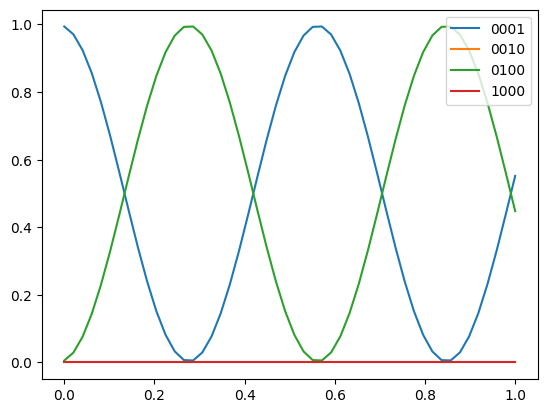

In [23]:
# Block 2

initial_state = states_block1[-1]

num_steps_block2 = 50
T_block2_list = np.linspace(0, 1, num_steps_block2)
delta_t_block2 = T_block2_list[1] - T_block2_list[0]

# Store states after every time step

states_block2 = []
states_block2.append(states_block1[-1])


print('Running block 2...')
for i in tqdm(range(num_steps_block2-1)):
    problem = TimeEvolutionProblem(H_spinsplit(E_spin) + H_chargesplit(E_charge_drive) + H_LZSI(eps, w_spin, 0), initial_state=states_block2[-1], time=delta_t_block2)
    trotter = TrotterQRTE(num_timesteps=1)
    result = trotter.evolve(problem)    
    states_block2.append(Statevector(result.evolved_state))


prob_dict_block2 = {'0000': [], '0001': [], '0010': [], '0011': [], 
                    '0100': [], '0101': [], '0110': [], '0111': [], 
                    '1000': [], '1001': [], '1010': [], '1011': [], 
                    '1100': [], '1101': [], '1110': [], '1111': []}

for states in states_block2:
    for key in states.probabilities_dict().keys():
        if states.probabilities_dict()[key] < 1e-15:
            prob_dict_block2[key].append(0)
        else:
            prob_dict_block2[key].append(states.probabilities_dict()[key])
    for key in prob_dict_block2.keys():
        if key not in states.probabilities_dict().keys():
            prob_dict_block2[key].append(0)


# Plot the probabilities of the states in the computational basis vs time
plt.figure()
plt.plot(T_block2_list, np.array(prob_dict_block2['0001']), label='0001')
plt.plot(T_block2_list, np.array(prob_dict_block2['0010']), label='0010')
plt.plot(T_block2_list, np.array(prob_dict_block2['0100']), label='0100')
plt.plot(T_block2_list, np.array(prob_dict_block2['1000']), label='1000')
plt.legend()
plt.show()

In [ ]:
# Block 3

initial_state = states_block2[-1]

num_steps_block3 = 50
T_block3_list = np.linspace(0, drivetime, num_steps_block3)
delta_t_block3 = T_block3_list[1] - T_block3_list[0]

# Prepare H_0
H_0_list = []
for t in T_block3_list:
    H_0_list.append(H_spinsplit(E_spin) + H_chargesplit(E_charge_drive + (E_charge-E_charge_drive)*t/drivetime))

# Store states after every time step

states_block3 = []
states_block3.append(states_block2[-1])

print('Running block 3...')
for i in tqdm(range(num_steps_block3-1)):
    problem = TimeEvolutionProblem(H_0_list[i] + H_LZSI(eps, w_spin, 0), initial_state=states_block3[-1], time=delta_t_block3)
    trotter = TrotterQRTE(num_timesteps=1)
    result = trotter.evolve(problem)    
    states_block3.append(Statevector(result.evolved_state))


prob_dict_block3 = {'0001': [], '0010': [], '0100': [], '1000': []}

for states in states_block3:
    for key in states.probabilities_dict().keys():
        if states.probabilities_dict()[key] < 1e-15:
            prob_dict_block3[key].append(0)
        else:
            prob_dict_block3[key].append(states.probabilities_dict()[key])
    for key in prob_dict_block3.keys():
        if key not in states.probabilities_dict().keys():
            prob_dict_block3[key].append(0)